## Importation des librairies

Initialisation de la date et du chemin d'export

In [1]:
from pathlib import Path
from pyomeca import Analogs
from scipy import signal, fftpack, fft, integrate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xarray as xr
import feather
import csv
import re
import seaborn.objects as so
import matplotlib as mpl
import os
from scipy.signal import butter, filtfilt
from scipy.stats import chi2
from matplotlib.patches import Ellipse
from itertools import chain
import configparser
import tkinter as tk
from tkinter import filedialog

from datetime import date

today = date.today().strftime("%Y%m%d")

path_export = "C:/Users/l.boisson/Documents/ActivGun/Exports/"

sns.set_theme()
sns.set_style("white")

## Détermination du chemin d'import des fichiers

In [2]:
# Create a GUI window
root = tk.Tk()
root.withdraw()  # Hide the main window

# Ask user to select the data folder using a file explorer dialog
# Check if data_folder_path is already loaded in Jupyter variables
try:
    data_folder_path
except NameError:
    data_folder_path = None

if data_folder_path is None:
    root = tk.Tk()
    root.withdraw()  # Hide the main window

    # Open file explorer dialog to select the data folder
    data_folder_path = filedialog.askdirectory(title="Select Data Folder")

    if not data_folder_path:
        print("No folder selected. Exiting.")
        exit()
Data_Path = Path(data_folder_path)

## Définition des fonctions

In [3]:
# Assignation du participant, de la condition, de la contraction, de l'essai et de la mesure pour chaque fichier
def extract_file_info(file_path):
    match_participant = re.search(r"(\d{3})", file_path)
    participant = match_participant.group() if match_participant else None
    
    match_condition = re.search(r"(CH|H|CTRL)", file_path)
    condition = match_condition.group() if match_condition else None
    
    match_contraction = re.search(r"(CON60|EXC|ISO)", file_path)
    contraction = match_contraction.group() if match_contraction else None
    
    match_essai = re.search(r"_(\d{1})_", file_path)
    essai = match_essai.group(1) if match_essai else None
    
    if contraction == 'EXC':
        match_essai = re.search(r"(?<=_)\w{1,2}(?=.cxp)", file_path)
        essai = match_essai.group() if match_essai else None
        mesure = 0
    
    else:
        match_mesure = re.search(r"(?<=_)\w{2}(?=.cxp)", file_path)
        mesure = match_mesure.group() if match_mesure else None
        
    return {
        "participant": participant,
        "condition": condition,
        "contraction": contraction,
        "essai": essai,
        "mesure": mesure
    }

# Fonction de mise en forme de df par participant et sans essai
def process_data_participant(df, variable):
    df.columns =  ['participant', 'condition', 'contraction', 'mesure', variable, 'SD', 'CV']
    df = df.drop(columns=['contraction'])
    df = df.pivot_table(index=["mesure"], columns=["condition", "participant"])
    df = df[[variable, 'SD', 'CV']]
    return df

# Fonction de mise en forme de df par participant et avec essai
def process_data_essai(df, variable):
    df.columns =  ['participant', 'condition', 'contraction', 'mesure', 'essai', variable, 'SD', 'CV']
    df = df.drop(columns=['contraction'])
    df = df.pivot_table(index=["essai"], columns=["condition", "participant"])
    df = df[[variable, 'SD', 'CV']]
    return df

# Fonction de mise en forme de df avec participants moyennés et sans essai
def process_data(df, variable):
    df.columns =  ['condition', 'contraction', 'mesure', variable, 'SD', 'CV']
    df = df.drop(columns=['contraction'])
    df = df.pivot_table(index=["mesure"], columns=["condition"])
    df = df[[variable, 'SD', 'CV']]
    return df

# Fonction de mise en forme de df avec participants moyennés et avec essai
def process_data_essai_participant(df, variable):
    df.columns =  ['condition', 'contraction', 'mesure', 'essai', variable, 'SD', 'CV']
    df = df.drop(columns=['contraction'])
    df = df.pivot_table(index=["essai"], columns=["condition"])
    df = df[[variable, 'SD', 'CV']]
    return df

## Extraction des données de chaque répétition, application du filtre, assignation des informations identifiant chaque donnée et mise en forme du dataframe

In [4]:
Data_Path

WindowsPath('C:/Users/l.boisson/Documents/ActivGun/Manips_test')

In [5]:
df_column = pd.DataFrame()

for filename in Data_Path.glob("**/*.cxp"):
    print(filename)
    file_path = filename.as_posix()
    file_info = extract_file_info(filename.name)
    print(file_info)
    contraction_type = file_info["contraction"]
    
    if contraction_type in ["EXC"]:
        print(filename.name)
        data = pd.read_table(
            filename.as_posix(),
            on_bad_lines="skip",
            encoding="utf-8",
            skiprows=193,
            header=0,
            nrows=14,
            names=["variable", "1", "2", "3", "4", "5"],
        )
    if contraction_type in ["ISO"]:
        data = pd.read_table(
            filename.as_posix(),
            on_bad_lines="skip",
            encoding="utf-8",
            skiprows=134,
            header=0,
            nrows=14,
            names=["variable", "1"],
        )
    if contraction_type in ["CON60"]:
        data = pd.read_table(
            filename.as_posix(),
            on_bad_lines="skip",
            encoding="utf-8",
            skiprows=193,
            header=0,
            nrows=14,
            names=["variable", "1", "2", "3"],
        )
    data = data.assign(**file_info)

    df_column = pd.concat([df_column, data])

df_column

df_column["mouvement"] = df_column["variable"].str.extract(r"(\d+)$")
df_column["variable"] = df_column["variable"].str.replace(r"\d+$", "")
df_column["mouvement"] = df_column["mouvement"].astype(int)
df_column["mouvement"] = df_column["mouvement"].replace({1: "Extension", 2: "Flexion"})

df_result = df_column.melt(
    id_vars=[
        "participant",
        "condition",
        "contraction",
        "essai",
        "mesure",
        "mouvement",
        "variable"
    ],
    value_vars=["1", "2", "3", "4", "5"],
    var_name="Repetition",
    value_name="Valeur",
)
df_result
df_result["Valeur"] = df_result["Valeur"].abs()
df_result = df_result[
    [
        "participant",
        "condition",
        "contraction",        
        "essai",
        "mesure",
        "mouvement",
        "variable",
        "Repetition",
        "Valeur"
    ]
]

df_result.columns = [
    "participant",
    "condition",
    "contraction",
    "essai",
    "mesure",
    "mouvement",
    "Variable",
    "Repetition",
    "Valeur"
]

df_result = pd.pivot_table(
    df_result,
    index=[
        "participant",
        "condition",
        "contraction",
        "essai",
        "mesure",
        "Repetition",
        "mouvement",
    ],
    columns=["Variable"],
    values="Valeur",
)

df_result

C:\Users\l.boisson\Documents\ActivGun\Manips_test\001_CH_CON60_1_01.cxp
{'participant': '001', 'condition': 'CH', 'contraction': 'CON60', 'essai': '1', 'mesure': '01'}
C:\Users\l.boisson\Documents\ActivGun\Manips_test\001_CH_CON60_1_02.cxp
{'participant': '001', 'condition': 'CH', 'contraction': 'CON60', 'essai': '1', 'mesure': '02'}
C:\Users\l.boisson\Documents\ActivGun\Manips_test\001_CH_CON60_1_11.cxp
{'participant': '001', 'condition': 'CH', 'contraction': 'CON60', 'essai': '1', 'mesure': '11'}
C:\Users\l.boisson\Documents\ActivGun\Manips_test\001_CH_EXC_1.cxp
{'participant': '001', 'condition': 'CH', 'contraction': 'EXC', 'essai': '1', 'mesure': 0}
001_CH_EXC_1.cxp
C:\Users\l.boisson\Documents\ActivGun\Manips_test\001_CH_EXC_10.cxp
{'participant': '001', 'condition': 'CH', 'contraction': 'EXC', 'essai': '10', 'mesure': 0}
001_CH_EXC_10.cxp
C:\Users\l.boisson\Documents\ActivGun\Manips_test\001_CH_EXC_2.cxp
{'participant': '001', 'condition': 'CH', 'contraction': 'EXC', 'essai': '2'

C:\Users\l.boisson\AppData\Local\Temp\ipykernel_9504\310123061.py:48: FutureWarning: The default value of regex will change from True to False in a future version.
  df_column["variable"] = df_column["variable"].str.replace(r"\d+$", "")


Variable                                                             power avg   \
participant condition contraction essai mesure Repetition mouvement               
001         CH        CON60       1     01     1          Extension  124.803660   
                                                          Flexion      4.235856   
                                               2          Extension  119.613529   
                                                          Flexion      3.342762   
                                               3          Extension  119.079906   
...                                                                         ...   
008         CTRL      ISO         2     02     1          Flexion      0.000000   
                                        11     1          Extension    0.299561   
                                                          Flexion      0.000000   
                                        21     1          Extension    0.031399   
                                                          Flexion      0.000000   

Variable                                                             power peak   \
participant condition contraction essai mesure Repetition mouvement                
001         CH        CON60       1     01     1          Extension   180.532925   
                                                          Flexion      11.409811   
                                               2          Extension   166.395320   
                                                          Flexion      11.766476   
                                               3          Extension   176.456704   
...                                                                          ...   
008         CTRL      ISO         2     02     1          Flexion       0.000000   
                                        11     1          Extension     0.872181   
                                                          Flexion       0.000000   
                                        21     1          Extension     0.922884   
                                                          Flexion       0.000000   

Variable                                                             speed peak   \
participant condition contraction essai mesure Repetition mouvement                
001         CH        CON60       1     01     1          Extension    60.924488   
                                                          Flexion      61.315025   
                                               2          Extension    60.533943   
                                                          Flexion      60.924488   
                                               3          Extension    60.533943   
...                                                                          ...   
008         CTRL      ISO         2     02     1          Flexion       0.000000   
                                        11     1          Extension     0.390542   
                                                          Flexion       0.390542   
                                        21     1          Extension     0.390542   
                                                          Flexion       0.000000   

Variable                                                             speed peak pos   \
participant condition contraction essai mesure Repetition mouvement                    
001         CH        CON60       1     01     1          Extension        71.147216   
                                                          Flexion          88.277651   
                                               2          Extension        76.418002   
                                                          Flexion          78.090008   
                                               3          Extension        91.398932   
...                                                                              ...   
008         CTRL      ISO     

## Renommage des colonnes

In [6]:
df_result.columns = ['Puissance_moyenne', 
                     'Pic_puissance', 
                     'Pic_vitesse', 
                     'Position_pic_vitesse', 
                     'Couple', 
                     'Position_couple', 
                     'Travail'
                     ]

df_result = df_result.drop(columns=['Puissance_moyenne', 'Pic_puissance', 'Pic_vitesse', 'Position_pic_vitesse'])

df_result

Couple  \
participant condition contraction essai mesure Repetition mouvement               
001         CH        CON60       1     01     1          Extension  171.792894   
                                                          Flexion    123.180081   
                                               2          Extension  159.033441   
                                                          Flexion    106.822659   
                                               3          Extension  168.530394   
...                                                                         ...   
008         CTRL      ISO         2     02     1          Flexion    252.453613   
                                        11     1          Extension  260.307495   
                                                          Flexion    254.203979   
                                        21     1          Extension  272.743286   
                                                          Flexion    256.141724   

                                                                     Position_couple  \
participant condition contraction essai mesure Repetition mouvement                    
001         CH        CON60       1     01     1          Extension        76.302059   
                                                          Flexion         107.705568   
                                               2          Extension        75.717773   
                                                          Flexion         107.708619   
                                               3          Extension        62.836003   
...                                                                              ...   
008         CTRL      ISO         2     02     1          Flexion          90.111365   
                                        11     1          Extension        90.111365   
                                                          Flexion          90.111365   
                                        21     1          Extension        90.109840   
                                                          Flexion          90.109840   

                                                                        Travail  
participant condition contraction essai mesure Repetition mouvement              
001         CH        CON60       1     01     1          Extension  142.354175  
                                                          Flexion      4.715699  
                                               2          Extension  132.696258  
                                                          Flexion      3.812837  
                                               3          Extension  135.360362  
...                                                                         ...  
008         CTRL      ISO         2     02     1          Flexion      0.000000  
                                        11     1          Extension    1.497807  
                                                          Flexion      0.000000  
                                        21     1          Extension    0.156995  
                                                          Flexion      0.000000  

[2624 rows x 3 columns]

# Sélection du mouvement adéquat

## Fichiers EXC
10 essais et 5 rep - 1 extension - 2 flexion (à prendre en compte)

## Fichiers CON
1 essai et 3 répétitions - 1 extension (à prendre en compte) - 2 flexion

## ISO
2 essais et 1 répétition - 1 extension (à prendre en compte) - 2 flexion

In [7]:
df_result = df_result[~((df_result.index.get_level_values('contraction') == 'CON60') & (df_result.index.get_level_values('mouvement') == 'Flexion'))]
df_result = df_result[~((df_result.index.get_level_values('contraction') == 'EXC') & (df_result.index.get_level_values('mouvement') == 'Extension'))]
df_result = df_result[~((df_result.index.get_level_values('contraction') == 'ISO') & (df_result.index.get_level_values('mouvement') == 'Flexion'))]
df_result

Couple  \
participant condition contraction essai mesure Repetition mouvement               
001         CH        CON60       1     01     1          Extension  171.792894   
                                               2          Extension  159.033441   
                                               3          Extension  168.530394   
                                        02     1          Extension  158.456253   
                                               2          Extension  151.376175   
...                                                                         ...   
008         CTRL      ISO         1     21     1          Extension  281.019073   
                                  2     01     1          Extension  271.703461   
                                        02     1          Extension  266.125488   
                                        11     1          Extension  260.307495   
                                        21     1          Extension  272.743286   

                                                                     Position_couple  \
participant condition contraction essai mesure Repetition mouvement                    
001         CH        CON60       1     01     1          Extension        76.302059   
                                               2          Extension        75.717773   
                                               3          Extension        62.836003   
                                        02     1          Extension        72.439359   
                                               2          Extension        74.077803   
...                                                                              ...   
008         CTRL      ISO         1     21     1          Extension        90.109840   
                                  2     01     1          Extension        90.109840   
                                        02     1          Extension        90.111365   
                                        11     1          Extension        90.111365   
                                        21     1          Extension        90.109840   

                                                                        Travail  
participant condition contraction essai mesure Repetition mouvement              
001         CH        CON60       1     01     1          Extension  142.354175  
                                               2          Extension  132.696258  
                                               3          Extension  135.360362  
                                        02     1          Extension  124.549599  
                                               2          Extension  121.009031  
...                                                                         ...  
008         CTRL      ISO         1     21     1          Extension    0.093675  
                                  2     01     1          Extension    1.591299  
                                        02     1          Extension    0.364501  
                                        11     1          Extension    1.497807  
                                        21     1          Extension    0.156995  

[1312 rows x 3 columns]

## Réinitialisation de l'index et suppression d'une exception

In [8]:
df_result.reset_index(inplace = True)
df_result = df_result[~((df_result.participant == '007') & (df_result.condition == 'CTRL') & (df_result.contraction == 'CON60') & (df_result.mesure == '11') & (df_result.Repetition == '1'))]
df_result

,participant,condition,contraction,essai,mesure,Repetition,mouvement,Couple,Position_couple,Travail
0,001,CH,CON60,1,01,1,Extension,171.792894,76.302059,142.354175
1,001,CH,CON60,1,01,2,Extension,159.033441,75.717773,132.696258
2,001,CH,CON60,1,01,3,Extension,168.530394,62.836003,135.360362
3,001,CH,CON60,1,02,1,Extension,158.456253,72.439359,124.549599
4,001,CH,CON60,1,02,2,Extension,151.376175,74.077803,121.009031
...,...,...,...,...,...,...,...,...,...,...
1307,008,CTRL,ISO,1,21,1,Extension,281.019073,90.109840,0.093675
1308,008,CTRL,ISO,2,01,1,Extension,271.703461,90.109840,1.591299
1309,008,CTRL,ISO,2,02,1,Extension,266.125488,90.111365,0.364501
1310,008,CTRL,ISO,2,11,1,Extension,260.307495,90.111365,1.497807


## [TEST] Affichage des données avec les conditions ci-dessous

In [9]:
test = df_result.reset_index()

test = test[~((test.participant == '007') & (test.condition == 'CTRL') & (test.contraction == 'CON60') & (test.mesure == '11') & (test.Repetition == '1'))]
test[(test.participant == '007') & (test.contraction == 'CON60')]

,index,participant,condition,contraction,essai,mesure,Repetition,mouvement,Couple,Position_couple,Travail
1032,1032,007,CTRL,CON60,1,01,1,Extension,214.860231,71.673532,170.040757
1033,1033,007,CTRL,CON60,1,01,2,Extension,210.454684,76.463768,180.134970
1034,1034,007,CTRL,CON60,1,01,3,Extension,192.259997,75.542334,168.418945
1035,1035,007,CTRL,CON60,1,02,1,Extension,208.649216,74.704805,152.685067
1036,1036,007,CTRL,CON60,1,02,2,Extension,198.639450,77.296720,162.419534
1037,1037,007,CTRL,CON60,1,02,3,Extension,186.188278,80.518688,162.556009
1038,1039,007,CTRL,CON60,1,11,2,Extension,180.573044,81.154844,139.949069
1039,1040,007,CTRL,CON60,1,11,3,Extension,172.760544,82.093059,143.070897
1040,1041,007,CTRL,CON60,1,21,1,Extension,178.143981,75.772693,110.928825
1041,1042,007,CTRL,CON60,1,21,2,Extension,184.870934,71.647597,105.024604


## [TEST] Affichage graphique des données avec les conditions ci-dessous

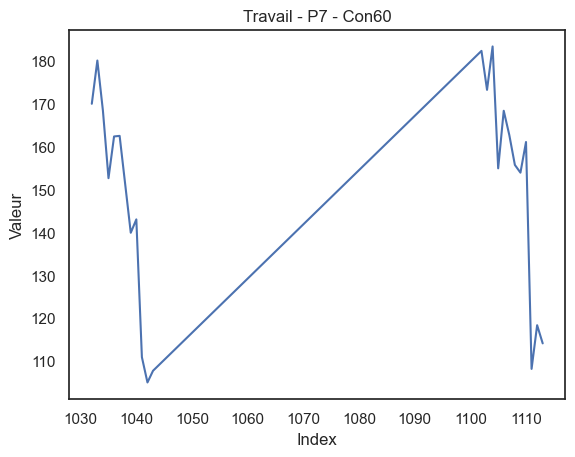

In [10]:
filtered_data = df_result[(df_result['participant'] == '007') & (df_result['contraction'] == 'CON60')]
travail_values = filtered_data['Travail']

plt.plot(travail_values)
plt.xlabel('Index')
plt.ylabel('Valeur')
plt.title('Travail - P7 - Con60')
plt.show()

## Importation du fichier contenant les poids de chaque participant en vue d'une normalisation des données

In [11]:
poids_file_path = "C:/Users/l.boisson/Documents/ActivGun/240327_ActivGun_Donnees_anthropometriques.xlsx"
poids_file = pd.DataFrame()
sheet_name = f'Composition_corporelle'
poids_file = pd.read_excel(poids_file_path, sheet_name=sheet_name, header=[0], nrows=2).iloc[:, 1:-2]
poids_file = poids_file.drop(poids_file.index[0]) 
poids_file.columns = poids_file.columns.str.replace('P', '')
poids_file = poids_file.melt(var_name='participant', value_name='poids')
poids_file

,participant,poids
0,001,61.0
1,002,68.2
2,003,82.9
3,004,61.9
4,005,90.5
5,006,107.6
6,007,74.3
7,008,70.0


## Normalisation du couple, du travail et de la position de couple max par le poids

In [12]:
df_result = pd.merge(df_result, poids_file, on="participant", how="left")
df_result["Couple_normalise"] = df_result["Couple"].div(df_result["poids"])
df_result["Travail_normalise"] = df_result["Travail"].div(df_result["poids"])
df_result

,participant,condition,contraction,essai,mesure,Repetition,mouvement,Couple,Position_couple,Travail,poids,Couple_normalise,Travail_normalise
0,001,CH,CON60,1,01,1,Extension,171.792894,76.302059,142.354175,61.0,2.816277,2.333675
1,001,CH,CON60,1,01,2,Extension,159.033441,75.717773,132.696258,61.0,2.607106,2.175348
2,001,CH,CON60,1,01,3,Extension,168.530394,62.836003,135.360362,61.0,2.762793,2.219022
3,001,CH,CON60,1,02,1,Extension,158.456253,72.439359,124.549599,61.0,2.597643,2.041797
4,001,CH,CON60,1,02,2,Extension,151.376175,74.077803,121.009031,61.0,2.481577,1.983755
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,008,CTRL,ISO,1,21,1,Extension,281.019073,90.109840,0.093675,70.0,4.014558,0.001338
1307,008,CTRL,ISO,2,01,1,Extension,271.703461,90.109840,1.591299,70.0,3.881478,0.022733
1308,008,CTRL,ISO,2,02,1,Extension,266.125488,90.111365,0.364501,70.0,3.801793,0.005207
1309,008,CTRL,ISO,2,11,1,Extension,260.307495,90.111365,1.497807,70.0,3.718679,0.021397


# Livrables CON60 par participant

### Calcul et mise en forme des variables 

In [13]:
df_result_con60 = df_result[df_result.contraction == 'CON60']

con60_couple_max = df_result_con60.groupby(['participant', 'condition', 'contraction', 'mesure'])['Couple'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
con60_couple_max_normalise = df_result_con60.groupby(['participant', 'condition', 'contraction', 'mesure'])['Couple_normalise'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
con60_couple_mean = df_result_con60.groupby(['participant', 'condition', 'contraction', 'mesure'])['Couple'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
con60_couple_mean_normalise = df_result_con60.groupby(['participant', 'condition', 'contraction', 'mesure'])['Couple_normalise'].agg(['mean', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
con60_pos_couple_max = df_result_con60.groupby(['participant', 'condition', 'contraction', 'mesure'])['Position_couple'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
con60_travail_moyen = df_result_con60.groupby(['participant', 'condition', 'contraction', 'mesure'])['Travail'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
con60_travail_moyen_normalise = df_result_con60.groupby(['participant', 'condition', 'contraction', 'mesure'])['Travail_normalise'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
con60_travail_max = df_result_con60.groupby(['participant', 'condition', 'contraction', 'mesure'])['Travail'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()

con60_couple_max = process_data_participant(con60_couple_max, 'Couple_max')
con60_couple_max_normalise = process_data_participant(con60_couple_max_normalise, 'Couple_max_normalise')
con60_couple_mean = process_data_participant(con60_couple_mean, 'Moy_couple_max')
con60_couple_mean_normalise = process_data_participant(con60_couple_mean_normalise, 'Moy_couple_max_normalise')
con60_pos_couple_max = process_data_participant(con60_pos_couple_max, 'Position_couple_max')
con60_travail_moyen = process_data_participant(con60_travail_moyen, 'Travail_moyen')
con60_travail_moyen_normalise = process_data_participant(con60_travail_moyen_normalise, 'Travail_moyen_normalise')
con60_travail_max = process_data_participant(con60_travail_max, 'Travail_max')

### Export des variables

In [14]:
with pd.ExcelWriter(path_export + f"{today}_ActivGun_concentrique_participant.xlsx") as writer:

    con60_couple_max.to_excel(writer, sheet_name='Couple_max')
    con60_couple_max_normalise.to_excel(writer, sheet_name='Couple_max_normalise')
    con60_couple_mean.to_excel(writer, sheet_name='Moy_couple_max')
    con60_couple_mean_normalise.to_excel(writer, sheet_name='Moy_couple_max_normalise')
    con60_pos_couple_max.to_excel(writer, sheet_name='Pos_couple_max')
    con60_travail_moyen.to_excel(writer, sheet_name='Travail_moyen')
    con60_travail_moyen_normalise.to_excel(writer, sheet_name='Travail_moyen_normalise')
    con60_travail_max.to_excel(writer, sheet_name='Travail_max')

# Livrables CON60 avec participants moyennés

### Calcul et mise en forme des variables 

In [15]:
con60_couple_max = df_result_con60.groupby(['condition', 'contraction', 'mesure'])['Couple'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
con60_couple_max_normalise = df_result_con60.groupby(['condition', 'contraction', 'mesure'])['Couple_normalise'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
con60_couple_mean = df_result_con60.groupby(['condition', 'contraction', 'mesure'])['Couple'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
con60_couple_mean_normalise = df_result_con60.groupby(['condition', 'contraction', 'mesure'])['Couple_normalise'].agg(['mean', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
con60_pos_couple_max = df_result_con60.groupby(['condition', 'contraction', 'mesure'])['Position_couple'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
con60_travail_moyen = df_result_con60.groupby(['condition', 'contraction', 'mesure'])['Travail'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
con60_travail_moyen_normalise = df_result_con60.groupby(['condition', 'contraction', 'mesure'])['Travail_normalise'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
con60_travail_max = df_result_con60.groupby(['condition', 'contraction', 'mesure'])['Travail'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()

con60_couple_max = process_data(con60_couple_max, 'Couple_max')
con60_couple_max_normalise = process_data(con60_couple_max_normalise, 'Couple_max_normalise')
con60_couple_mean = process_data(con60_couple_mean, 'Moy_couple_max')
con60_couple_mean_normalise = process_data(con60_couple_mean_normalise, 'Moy_couple_max_normalise')
con60_pos_couple_max = process_data(con60_pos_couple_max, 'Position_couple_max')
con60_travail_moyen = process_data(con60_travail_moyen, 'Travail_moyen')
con60_travail_moyen_normalise = process_data(con60_travail_moyen_normalise, 'Travail_moyen_normalise')
con60_travail_max = process_data(con60_travail_max, 'Travail_max')
con60_couple_mean

Moy_couple_max                                 SD             \
condition             CH        CTRL           H         CH       CTRL   
mesure                                                                   
01            200.283939  200.028313  205.571114  52.274139  47.237064   
02            187.569535  184.482241  184.840064  47.692774  42.735662   
11            168.283083  157.082622  181.005552  56.325878  44.961117   
21            184.074916  158.303578  196.002143  50.277730  46.717023   

                            CV                      
condition          H        CH      CTRL         H  
mesure                                              
01         43.906830  0.253647  0.231180  0.206342  
02         37.425576  0.247103  0.226774  0.195610  
11         42.872146  0.325279  0.278979  0.228824  
21         38.457412  0.263876  0.287998  0.189556

### Export des variables

In [16]:
with pd.ExcelWriter(path_export + f"{today}_ActivGun_concentrique.xlsx") as writer:
    con60_couple_max.to_excel(writer, sheet_name='Couple_max')
    con60_couple_max_normalise.to_excel(writer, sheet_name='Couple_max_normalise')
    con60_couple_mean.to_excel(writer, sheet_name='Moy_couple_max')
    con60_couple_mean_normalise.to_excel(writer, sheet_name='Moy_couple_max_normalise')
    con60_pos_couple_max.to_excel(writer, sheet_name='Pos_couple_max')
    con60_travail_moyen.to_excel(writer, sheet_name='Travail_moyen')
    con60_travail_moyen_normalise.to_excel(writer, sheet_name='Travail_moyen_normalise')
    con60_travail_max.to_excel(writer, sheet_name='Travail_max')

# Livrables ISO par participant

### Calcul et mise en forme des variables 

In [17]:
df_result_iso = df_result[df_result.contraction == 'ISO']
iso_couple_max = df_result_iso.groupby(['participant', 'condition', 'contraction', 'mesure'])['Couple'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
iso_couple_max_normalise = df_result_iso.groupby(['participant', 'condition', 'contraction', 'mesure'])['Couple_normalise'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
iso_couple_mean = df_result_iso.groupby(['participant', 'condition', 'contraction', 'mesure'])['Couple'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
iso_couple_mean_normalise = df_result_iso.groupby(['participant', 'condition', 'contraction', 'mesure'])['Couple_normalise'].agg(['mean', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
iso_travail_moyen = df_result_iso.groupby(['participant', 'condition', 'contraction', 'mesure'])['Travail'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
iso_travail_moyen_normalise = df_result_iso.groupby(['participant', 'condition', 'contraction', 'mesure'])['Travail_normalise'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
iso_travail_max = df_result_iso.groupby(['participant', 'condition', 'contraction', 'mesure'])['Travail'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()

iso_couple_max = process_data_participant(iso_couple_max, 'Couple_max')
iso_couple_max_normalise = process_data_participant(iso_couple_max_normalise, 'Couple_max_normalise')
iso_couple_mean = process_data_participant(iso_couple_mean, 'Moy_couple_max')
iso_couple_mean_normalise = process_data_participant(iso_couple_mean_normalise, 'Moy_couple_max_normalise')
iso_travail_moyen = process_data_participant(iso_travail_moyen, 'Travail_moyen')
iso_travail_moyen_normalise = process_data_participant(iso_travail_moyen_normalise, 'Travail_moyen_normalise')
iso_travail_max = process_data_participant(iso_travail_max, 'Travail_max')
iso_couple_max_normalise

Couple_max_normalise                                          \
condition                     CH                                           
participant                  001       002       003       004       006   
mesure                                                                     
01                      2.849343  3.453622  2.744983  2.879541  3.215123   
02                      2.670833  3.390184  2.977578  2.699594  3.027624   
11                      2.313278  3.129213  2.918088  2.052395  2.730522   
21                      2.515261  3.294351  2.696241  2.168929  2.694070   

                                                               ...        CV  \
condition                  CTRL                                ...      CTRL   
participant       008       001       002       003       004  ...       004   
mesure                                                         ...             
01           4.308726  2.965345  3.341919  2.812849  2.742638  ...  0.019720   
02           4.456903  2.610138  3.393759  2.646131  2.828508  ...  0.043221   
11           4.879381  2.310645  2.890746  2.497160  2.180766  ...  0.017476   
21           4.948321  2.301059  3.061932  2.299620  1.971718  ...  0.081099   

                                                                         \
condition                                                   H             
participant       005       006       007       008       001       002   
mesure                                                                    
01           0.020184  0.027314  0.089305  0.024567  0.034683  0.000458   
02           0.001185  0.034010  0.021293  0.020953  0.020315  0.013765   
11                NaN  0.029972  0.022184  0.003767  0.010697  0.016371   
21                NaN  0.059104  0.003426  0.014725  0.031475  0.010825   

                                           
condition                                  
participant       003       005       007  
mesure                                     
01           0.033215  0.012143  0.005095  
02           0.016622  0.019408  0.000600  
11           0.021166  0.001547  0.000553  
21           0.035956  0.010345  0.004760  

[4 rows x 57 columns]

### Export des variables

In [18]:
with pd.ExcelWriter(path_export + f"{today}_ActivGun_isometrique_participant.xlsx") as writer:
    iso_couple_max.to_excel(writer, sheet_name='Couple_max')
    iso_couple_max_normalise.to_excel(writer, sheet_name='Couple_max_normalise')
    iso_couple_mean.to_excel(writer, sheet_name='Moy_couple_max')
    iso_couple_mean_normalise.to_excel(writer, sheet_name='Moy_couple_max_normalise')
    iso_travail_moyen.to_excel(writer, sheet_name='Travail_moyen')
    iso_travail_moyen_normalise.to_excel(writer, sheet_name='Travail_moyen_normalise')
    iso_travail_max.to_excel(writer, sheet_name='Travail_max')

# Livrables ISO avec participants moyennés

### Calcul et mise en forme des variables 

In [19]:
iso_couple_max = df_result_iso.groupby(['condition', 'contraction', 'mesure'])['Couple'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
iso_couple_max_normalise = df_result_iso.groupby(['condition', 'contraction', 'mesure'])['Couple_normalise'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
iso_couple_mean = df_result_iso.groupby(['condition', 'contraction', 'mesure'])['Couple'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
iso_couple_mean_normalise = df_result_iso.groupby(['condition', 'contraction', 'mesure'])['Couple_normalise'].agg(['mean', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
iso_travail_moyen = df_result_iso.groupby(['condition', 'contraction', 'mesure'])['Travail'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
iso_travail_moyen_normalise = df_result_iso.groupby(['condition', 'contraction', 'mesure'])['Travail_normalise'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
iso_travail_max = df_result_iso.groupby(['condition', 'contraction', 'mesure'])['Travail'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()

iso_couple_max = process_data(iso_couple_max, 'Couple_max')
iso_couple_max_normalise = process_data(iso_couple_max_normalise, 'Couple_max_normalise')
iso_couple_mean = process_data(iso_couple_mean, 'Moy_couple_max')
iso_couple_mean_normalise = process_data(iso_couple_mean_normalise, 'Moy_couple_max_normalise')
iso_travail_moyen = process_data(iso_travail_moyen, 'Travail_moyen')
iso_travail_moyen_normalise = process_data(iso_travail_moyen_normalise, 'Travail_moyen_normalise')
iso_travail_max = process_data(iso_travail_max, 'Travail_max')
iso_couple_max_normalise

Couple_max_normalise                            SD            \
condition                   CH      CTRL         H        CH      CTRL   
mesure                                                                   
01                    4.308726  4.082043  3.644189  0.526732  0.450658   
02                    4.456903  3.801793  3.464338  0.648226  0.394953   
11                    4.879381  3.718679  3.377824  0.920224  0.506908   
21                    4.948321  4.014558  3.694426  0.929438  0.672285   

                           CV                      
condition         H        CH      CTRL         H  
mesure                                             
01         0.374203  0.117043  0.106894  0.097415  
02         0.307384  0.139251  0.100587  0.084175  
11         0.366058  0.180565  0.131356  0.102810  
21         0.486403  0.179833  0.161370  0.124902

### Export des variables

In [20]:
with pd.ExcelWriter(path_export + f"{today}_ActivGun_isometrique.xlsx") as writer:

    iso_couple_max.to_excel(writer, sheet_name='Couple_max')
    iso_couple_max_normalise.to_excel(writer, sheet_name='Couple_max_normalise')
    iso_couple_mean.to_excel(writer, sheet_name='Moy_couple_max')
    iso_couple_mean_normalise.to_excel(writer, sheet_name='Moy_couple_max_normalise')
    iso_travail_moyen.to_excel(writer, sheet_name='Travail_moyen')
    iso_travail_moyen_normalise.to_excel(writer, sheet_name='Travail_moyen_normalise')
    iso_travail_max.to_excel(writer, sheet_name='Travail_max')

# Livrables EXC par participant

### Calcul et mise en forme des variables 

In [21]:
df_result_exc = df_result[df_result.contraction == 'EXC']
df_result_exc['essai'] = df_result_exc['essai'].astype(int)
df_result_exc = df_result_exc.sort_values(by='essai')

exc_couple_max = df_result_exc.groupby(['participant', 'condition', 'contraction', 'mesure', 'essai'])['Couple'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
exc_couple_max_normalise = df_result_exc.groupby(['participant', 'condition', 'contraction', 'mesure', 'essai'])['Couple_normalise'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
exc_pos_couple_max = df_result_exc.groupby(['participant', 'condition', 'contraction', 'mesure', 'essai'])['Position_couple'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
exc_travail_moyen_participant_essai = df_result_exc.groupby(['participant', 'condition', 'contraction', 'mesure', 'essai'])['Travail'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
exc_travail_moyen_participant_essai_normalise = df_result_exc.groupby(['participant', 'condition', 'contraction', 'mesure', 'essai'])['Travail_normalise'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
exc_travail_moyen_participant = df_result_exc.groupby(['participant', 'condition', 'contraction', 'mesure'])['Travail'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
exc_travail_moyen_participant_normalise = df_result_exc.groupby(['participant', 'condition', 'contraction', 'mesure'])['Travail_normalise'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()

exc_couple_max = process_data_essai(exc_couple_max, 'Couple_max')
exc_couple_max_normalise = process_data_essai(exc_couple_max_normalise, 'Couple_max_normalise')
exc_pos_couple_max = process_data_essai(exc_pos_couple_max, 'Pos_couple_max')
exc_travail_moyen_participant_essai = process_data_essai(exc_travail_moyen_participant_essai, 'Travail_moyen_essai')
exc_travail_moyen_participant_essai_normalise = process_data_essai(exc_travail_moyen_participant_essai_normalise, 'Travail_moyen_normalise_essai')
exc_travail_moyen_participant = process_data_participant(exc_travail_moyen_participant, 'Travail_moyen')
exc_travail_moyen_participant_normalise = process_data_participant(exc_travail_moyen_participant_normalise, 'Travail_moyen_normalise')

C:\Users\l.boisson\AppData\Local\Temp\ipykernel_9504\960495664.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result_exc['essai'] = df_result_exc['essai'].astype(int)


In [22]:
exc_travail_moyen_participant_normalise

Travail_moyen_normalise                                          \
condition                        CH                                           
participant                     001       002       003       004       006   
mesure                                                                        
0                          2.269641  2.147368  2.628232  3.097642  2.679671   

                                                               ...        CV  \
condition                  CTRL                                ...      CTRL   
participant       008       001       002       003       004  ...       004   
mesure                                                         ...             
0            2.687669  2.668331  2.495157  2.697929  2.987851  ...  0.147941   

                                                                         \
condition                                                   H             
participant       005       006       007       008       001       002   
mesure                                                                    
0            0.214256  0.115144  0.190308  0.155317  0.088377  0.066267   

                                         
condition                                
participant     003       005       007  
mesure                                   
0            0.0903  0.148343  0.108964  

[1 rows x 57 columns]

### Export des variables

In [24]:
with pd.ExcelWriter(path_export + f"{today}_ActivGun_excentrique_participant.xlsx") as writer:
    exc_couple_max.to_excel(writer, sheet_name='Couple_max')
    exc_couple_max_normalise.to_excel(writer, sheet_name='Couple_max_normalise')
    exc_pos_couple_max.to_excel(writer, sheet_name='Pos_couple_max')
    exc_travail_moyen_participant_essai.to_excel(writer, sheet_name='Travail_moyen_essai')
    exc_travail_moyen_participant_essai_normalise.to_excel(writer, sheet_name='Travail_moyen_norm_essai')
    exc_travail_moyen_participant.to_excel(writer, sheet_name='Travail_moyen')
    exc_travail_moyen_participant_normalise.to_excel(writer, sheet_name='Travail_moyen_normalise')

# Livrables EXC avec participants moyennés

### Calcul et mise en forme des variables 

In [25]:
exc_couple_max = df_result_exc.groupby(['condition', 'contraction', 'mesure', 'essai'])['Couple'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
exc_couple_max_normalise = df_result_exc.groupby(['condition', 'contraction', 'mesure', 'essai'])['Couple_normalise'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
exc_pos_couple_max = df_result_exc.groupby(['condition', 'contraction', 'mesure', 'essai'])['Position_couple'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
exc_travail_moyen_essai = df_result_exc.groupby(['condition', 'contraction', 'mesure', 'essai'])['Travail'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
exc_travail_moyen_essai_normalise = df_result_exc.groupby(['condition', 'contraction', 'mesure', 'essai'])['Travail_normalise'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
exc_travail_moyen = df_result_exc.groupby(['condition', 'contraction', 'mesure'])['Travail'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
exc_travail_moyen_normalise = df_result_exc.groupby(['condition', 'contraction', 'mesure'])['Travail_normalise'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()

exc_couple_max = process_data_participant(exc_couple_max, 'Couple_max')
exc_couple_max_normalise = process_data_participant(exc_couple_max_normalise, 'Couple_max_normalise')
exc_pos_couple_max = process_data_participant(exc_pos_couple_max, 'Pos_couple_max')
exc_travail_moyen_essai = process_data_participant(exc_travail_moyen_essai, 'Travail_moyen_essai')
exc_travail_moyen_essai_normalise = process_data_participant(exc_travail_moyen_essai_normalise, 'Travail_moyen_normalise_essai')
exc_travail_moyen = process_data(exc_travail_moyen, 'Travail_moyen')
exc_travail_moyen_normalise = process_data(exc_travail_moyen_normalise, 'Travail_moyen_normalise')
exc_travail_moyen

Travail_moyen                                 SD             \
condition            CH        CTRL           H         CH       CTRL   
mesure                                                                  
0            195.223403  208.786722  188.889582  55.794137  51.427711   

                            CV                      
condition          H        CH      CTRL         H  
mesure                                              
0          37.201687  0.285312  0.246009  0.196555

### Export des variables

In [26]:
with pd.ExcelWriter(path_export + f"{today}_ActivGun_excentrique.xlsx") as writer:
    exc_couple_max.to_excel(writer, sheet_name='Couple_max')
    exc_couple_max_normalise.to_excel(writer, sheet_name='Couple_max_normalise')
    exc_pos_couple_max.to_excel(writer, sheet_name='Pos_couple_max')
    exc_travail_moyen_essai.to_excel(writer, sheet_name='Travail_moyen_essai')
    exc_travail_moyen_essai_normalise.to_excel(writer, sheet_name='Travail_moyen_norm_essai')
    exc_travail_moyen.to_excel(writer, sheet_name='Travail_moyen')
    exc_travail_moyen_normalise.to_excel(writer, sheet_name='Travail_moyen_normalise')